In [1]:
import os
import sys
import random
import time
from IPython.display import Audio

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import sawtooth
import torch
import torchaudio

from cxai.utils.dataloading import Loader
from cxai.utils.visualization import plot_waveform, plot_spectrogram

# Generate Toy Data

#### *NOTE: the following equations are from a previous version and have to be updated. However, they provide a brief introduction into the data generation process.*

Length of signals is set to 16000, with hypothetic sample rate of 16 kHz. Highest possible frequency is therefore 8 kHz (Nyquist-Shannon Frequency).


### Modulating amplitude:
General formula to construct modulating amplitude with a given frequency $k_{a_i}$.

$$ a_{mod_i}[n] = \alpha_i \cdot \sin(\frac{2 \pi \cdot k_{a_i} \cdot n}{N} + \phi_{a_i}) $$


### Frequency signal:
Signal at specific frequency $k_f$ with modulating amplitude. This amplitude gives the signal a specific structure (rythm).

$$ x_i[n] = a_{mod_i}[n] \cdot \sin(\frac{2 \pi \cdot k_{f_i} \cdot n}{N} + \phi_{f_i}) $$


## Three different class specific concepts
Each datapoint $x_i[n]$ is randomly constructed of 1-3 of the below listed class specific concepts. Then, a combination of 5 random structured sinusoid signals is added on top of the signal to introduce more randonmess. After superposing all signals, Gaussian-Noise with noise strength is added to the overall signal.

#### Concept 1:
Sinusodial signal with half-wave rectified sinusoid as modulating amplitude to obtain a drum like rythm. Both classes share the same frequency range for this concept but have different modulating amplitudes (rhytms) for the signal. Goal is that the model detects the rythmic structure of the signal.

$$ a_{mod_i}[n] = ReLU(a_{mod_i}[n]) $$

#### Concept 2:
Sinusodial signal with modulating amplitude and exponential decay. Both classes share the same frequency range and modulating amplitude but different exponential decay/growth.

First, the amplitude strength $\alpha_i$ is added to the signal to shift it above zero to ensure $a_{mod_i}[n] >= 0$. Then exponential decay is added to the signal, so that its amplitude is shrinking or growing over time with the factor $\lambda$.

$$ a_{mod_i}[n] =  [\alpha_i + a_{mod_i}[n]] \cdot e^{-\lambda} $$

#### Concept 3:
"Simple" signal with shared modulating amplitude but different frequency ranges for both classes. Goal is to detect the class specific frequency ranges as concept. Amplitude is again shifted to be semi-positive definite.

NEW: no modulating amplitude here

$$ a_{mod_i}[n] =  [\alpha_i + a_{mod_i}[n]] $$


## Shared concepts:
Same struture as concept 3 of the clas specific concepts. Each of these 5 random concepts is sampled randomly. The modulaiting amplitude is sampled linearly from a given frequency range. The frequency of the signal itself is sampled from an exponential distribution over the full posiible ferquency range [1,8000]Hz. The scale parameter is set such that the mean frequency is $E[x]=2000Hz$. Therfore we set the scale parameter $\beta$ to:

$$ \beta = 2000 $$

And sample for the random shared concepts from the exponential distribution:

$$ k_i = \max(1, \frac{1}{\beta} \cdot \exp(-\frac{x}{\beta})) $$









In [2]:
# define frequency ranges for different concepts
class_params = {
    'class1': {
        'concept1': {
            # full-wave rectified sinusoid (same frequency for both classes, different modulation) - rythimic structure
            'f_range': [100, 150], # [150,175],
            'f_amp': [16],
        },
        'concept2': {
            # same frequency and modulation for both classes, different decay rate (increasing)
            'f_range': [500, 600],
            'f_saw': [2],
            'direction': 1,
            #'mod_amp': [30,40],
            #'decay_rate': -0.8,
        },
        'concept3': {
            # same modulation for both classes, different frequency
            'f_range': [800, 1000],
            'f_amp': [3,6],
        },
        'concept4': {
            'f_range': [3500, 4000], # [3000, 3500]
            'f_amp': [20],   # 20, 24, als letztes war auch 8-10
        },
    },
    'class2': {
        'concept1': {
            # half-wave rectified sinusoid (same frequency for both classes, different modulation) - rythimic structure
            'f_range': [100, 150],
            'f_amp': [4,5],
        },
        'concept2': {
            # same frequency and modulation for both classes, different decay rate (increasing)
            'f_range': [500, 600],
            'f_saw': [2],
            'direction': -1,
            #'mod_amp': [30,40],
            #'decay_rate': -0.8,
        },
        'concept3': {
            # same modulation for both classes, different frequency
            'f_range': [800, 1000],
            'f_amp': [16],
        },
        'concept4': {
            'f_range': [4000, 4500], # [150,175],
            'f_amp': [10], #8,12
        },
    },
}

# define frequnecies for concept signals 
num_shared_concepts = 5
freq_range = [1,8000]
# scale for exp distribution to sample frequency from (scale is average value)
scale = 2000
#mod_range = [40,100]
#freqs_shared_concepts = [[340, 520], [1400, 2200], [2800, 5200]]


random_concepts = {
    'f_amp': [40, 100],
}


'''# define tranformations
transforms = [
        RandomApply([PitchShift(n_samples=N, sample_rate=N)], p=0.8),
        RandomApply([Delay(sample_rate=N, volume_factor=0.5, min_delay=50, max_delay=300)], p=0.6),
        RandomApply([Reverb(sample_rate=N)], p=0.6),
    ]
transform = Compose(transforms=transforms)'''

# function to sample random phase
def get_phase(min=0, max=2*np.pi):
    return random.uniform(min, max)

def relu(x):
    return x * (x > 0)

def get_rand(range_):
    return random.randint(range_[0], range_[1]+1) if len(range_) > 1 else int(range_[0])

def get_amp(min=0.6, max=1.):
    return random.uniform(min, max)

def norm(sig):
    return sig / np.abs(sig).max()

In [3]:
class_params

{'class1': {'concept1': {'f_range': [100, 150], 'f_amp': [16]},
  'concept2': {'f_range': [500, 600], 'f_saw': [2], 'direction': 1},
  'concept3': {'f_range': [800, 1000], 'f_amp': [3, 6]},
  'concept4': {'f_range': [3500, 4000], 'f_amp': [20]}},
 'class2': {'concept1': {'f_range': [100, 150], 'f_amp': [4, 5]},
  'concept2': {'f_range': [500, 600], 'f_saw': [2], 'direction': -1},
  'concept3': {'f_range': [800, 1000], 'f_amp': [16]},
  'concept4': {'f_range': [4000, 4500], 'f_amp': [10]}}}

In [4]:
tomel = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=480, n_mels=64, hop_length=240, pad_mode='reflect')


In [5]:
N = 16000
n = np.arange(N)

loader = Loader(case='toy')
tomel = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=480, n_mels=64, hop_length=240, pad_mode='reflect')

def sinusoid_sig(freq, n=np.arange(16000), N=16000):
    """
    """
    return get_amp() * np.sin(2 * np.pi * n * freq / N + get_phase())


def modulating_amp(f_amp, phase_amp, shift=0):
    """
    """
    return relu(np.sin(2 * np.pi * n * f_amp / N + phase_amp) + shift) / (shift+1) # accounts for normalization


def harmonic_sig(freq, harmonics=2):
    """
    """
    amp = get_amp()
    sig = amp * np.sin(2 * np.pi * n * freq / N + get_phase())
    for harmonic in range(1,harmonics+1):
        k = 1 / (2*harmonic)
        sig += k * amp * np.sin(2 * np.pi * n * (freq*harmonic) / N + get_phase())
    return sig


def alternating_sig(freq, f_amp, phase_amp, modulating_amplitude):
    """
    """
    # create empty signal tensor
    sig = np.zeros(N)
    # define period of the modulating amplitude
    T = N // f_amp
    frequency_step = 200
    # create array of varying frequency (increasing - decreasing) with 3 steps each
    freqs = freq + np.concatenate([np.arange(0,4)*frequency_step, np.arange(1,3)[::-1]*frequency_step])
    # sample startpoint to mask the modulating amplitude
    # has to start in first half so complete melodic structure is in one piece in the sample
    s = np.random.choice(np.arange(0, f_amp//2))

    # f_amp=16, s<8

    for i in range(s, f_amp+1):
        # modulating amplitude is a signal with #f_amp sound bumps
        # we genrate such a signal for ever frequency defined in freqs
        # then we extract at 12 consecutive locations those bumpy and add them to the final signal        
        if i == s+12: break
        # modulating amplitude masks the original signal to get #f_amp single 'bumps' of sound
        signal1 = modulating_amplitude * sinusoid_sig(freqs[i%6], n, N)
        # caculate startpoint with period of modulating amplitude signal to extract one bump
        start = int((2*i * np.pi - phase_amp) * T / (2*np.pi))
        # add the bump at the original location
        sig[start:start+T] = signal1[start:start+T]

    return sig

def smooth_attack(saw, direction, f_saw, phase, kernel=160, N=16000):
    """
    """
    # smoothes the attack of a tone
    smoothing_mask = np.arange(kernel)/kernel
    T = N/f_saw
    s1 = int((2 * np.pi - phase) * T / (2*np.pi))
    
    if direction == -1:
        for i in range(f_saw):
            t_start = int(s1+i*T)
            saw[t_start:t_start+kernel] *= smoothing_mask
    else:
        for i in range(f_saw):
            t_start = int(s1+i*T)
            saw[t_start-kernel+3:t_start+3] *= smoothing_mask[::-1]
        #saw[np.argmax(saw)-kernel+1:np.argmax(saw)+1] *= smoothing_mask[::-1]
    return saw


def sawtooth_amp(f_saw, direction):
    """
    """
    f_saw = get_rand(f_saw)
    # generate sawtooth function (add 1 to shift signal below 0, divide by 2 to normalize)
    # welimit the phase here to be able to smooth the attack of the signal appropriately
    phase = get_phase(min=0.5, max=2*np.pi-0.5)
    saw = (direction * sawtooth(2 * np.pi * f_saw * n / N + phase) + 1) / 2
    # smooth the attack of the tone (otherwise there will be leakage in the spectrogram)
    return smooth_attack(saw, direction, f_saw, phase)


def mask_modulating_sig(f_amp, phase_amp, f_mask=2):
    start_phase = (phase_amp + 2*np.pi * np.random.choice(np.arange(1,(f_amp//2)-1))) / (f_amp/f_mask) 
    return (np.sin(2 * np.pi * n * f_mask / N + start_phase) >= 0) * 1.



def generate_class1_sample(params, concepts):
    signal = np.zeros(N)

    for concept_idx in concepts:
        if concept_idx == 1:
            # modulating rhytmic signal
            f_amp = get_rand(params['concept1']['f_amp'])
            phase_amp = get_phase()
            modulating_sig = modulating_amp(f_amp, phase_amp) * sinusoid_sig(get_rand(params['concept1']['f_range']), n, N)
            signal += modulating_sig * mask_modulating_sig(f_amp, phase_amp)
            
        elif concept_idx == 2:
            # sawtooth signal
            signal += sawtooth_amp(params['concept2']['f_saw'], params['concept2']['direction']) * sinusoid_sig(get_rand(params['concept2']['f_range']), n, N)
            #signal += sinusoid_sig(get_rand(params['concept2']['f_range']), n, N) * modulating_amp(get_rand(params['concept2']['f_amp']), get_phase(), shift=1)

        elif concept_idx == 3:
            # harmonic signal
            modulating_amplitude = modulating_amp(get_rand(params['concept3']['f_amp']), get_phase(), shift=3/4)
            signal += modulating_amplitude * harmonic_sig(get_rand(params['concept3']['f_range']))

        else:
            signal += sinusoid_sig(get_rand(params['concept4']['f_range']), n, N) * modulating_amp(get_rand(params['concept4']['f_amp']), get_phase(), shift=1)

    return signal


def generate_class2_sample(params, concepts):
    signal = np.zeros(N)

    for concept_idx in concepts:
        if concept_idx == 1:
            # modulating signal
            signal += modulating_amp(get_rand(params['concept1']['f_amp']), get_phase()) * sinusoid_sig(get_rand(params['concept1']['f_range']), n, N)

        elif concept_idx == 2:
            # sawtooth signal
            signal += sawtooth_amp(params['concept2']['f_saw'], params['concept2']['direction']) * sinusoid_sig(get_rand(params['concept2']['f_range']), n, N)

        elif concept_idx == 3:
            # alternating signal in frequency
            f_amp = get_rand(params['concept3']['f_amp'])
            phase_amp = get_phase()
            modulating_amplitude = modulating_amp(f_amp, phase_amp)
            signal += alternating_sig(get_rand(params['concept3']['f_range']), f_amp, phase_amp, modulating_amplitude)
        
        else:
            signal += sinusoid_sig(get_rand(params['concept4']['f_range']), n, N) * modulating_amp(get_rand(params['concept4']['f_amp']), get_phase(), shift=1)

    return signal


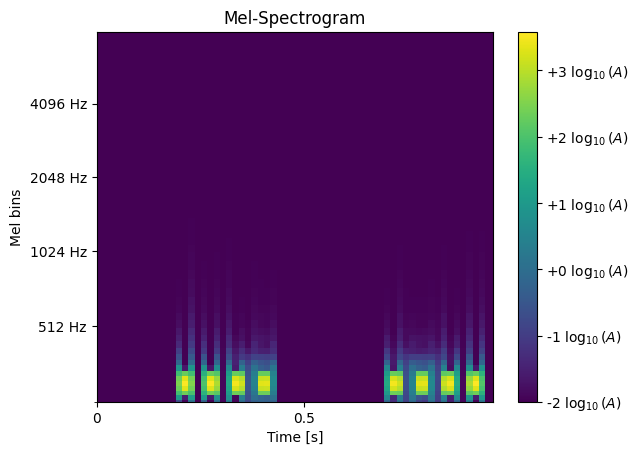

In [6]:
# c1
params = class_params['class1']

f_amp = np.random.choice(params['concept1']['f_amp'])
phase_amp = get_phase()
modulating_sig = modulating_amp(f_amp, phase_amp) * sinusoid_sig(np.random.choice(params['concept1']['f_range']), n, N)
signal = modulating_sig * mask_modulating_sig(f_amp, phase_amp)
signal11 = signal
mel = tomel(torch.tensor(signal, dtype=torch.float))
mel11 = np.log10(mel.numpy()+0.01).squeeze()
plot_spectrogram(np.log10(mel.numpy()+0.01).squeeze(), case='toy', colorbar=True)
Audio(signal, rate=16000)#, mel.shape

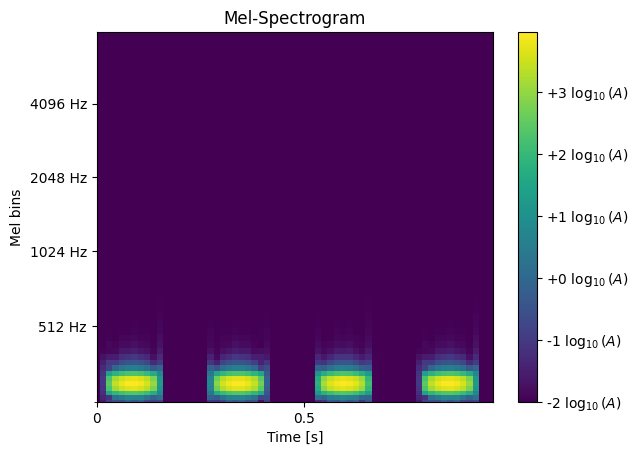

In [7]:
# CLASS 2
params = class_params['class2']

signal = modulating_amp(np.random.choice(params['concept1']['f_amp']), get_phase()) * sinusoid_sig(np.random.choice(params['concept1']['f_range']), n, N)
signal21 = signal
mel = tomel(torch.tensor(signal, dtype=torch.float))
mel21 = np.log10(mel.numpy()+0.01).squeeze()
plot_spectrogram(np.log10(mel.numpy()+0.01).squeeze(), case='toy')
Audio(signal[None], rate=16000)

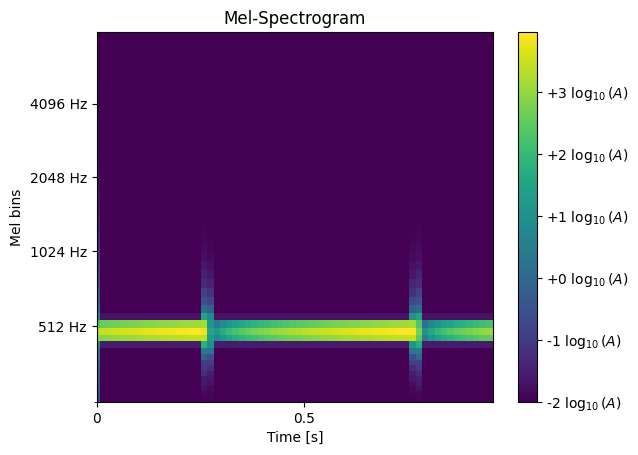

In [8]:
# CLASS 2
# c1
concept = class_params['class1']['concept2']

signal = sawtooth_amp(concept['f_saw'], concept['direction']) * sinusoid_sig(np.random.choice(concept['f_range']), n, N)
signal12 = signal
mel = tomel(torch.tensor(signal, dtype=torch.float))
mel12 = np.log10(mel.numpy()+0.01).squeeze()
plot_spectrogram(np.log10(mel.numpy()+0.01).squeeze(), case='toy')
Audio(signal, rate=16000)

0.6282508057127505 -0.6295362709089083


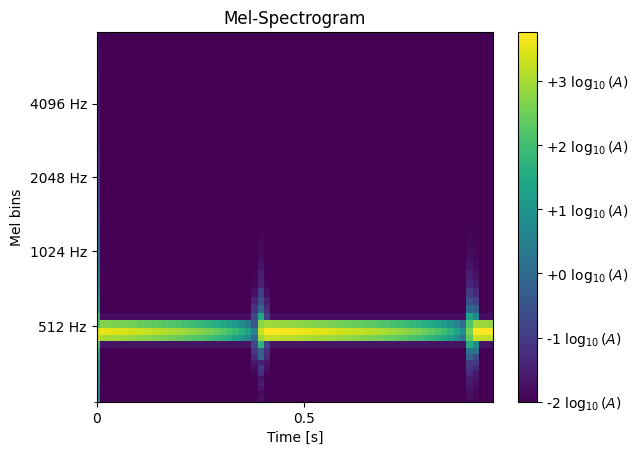

In [9]:
# CLASS 2
# c1
concept = class_params['class2']['concept2']

signal = sawtooth_amp(concept['f_saw'], concept['direction']) * sinusoid_sig(np.random.choice(concept['f_range']), n, N)
signal22 = signal
print(signal.max(), signal.min())
mel = tomel(torch.tensor(signal, dtype=torch.float))
mel22 = np.log10(mel.numpy()+0.01).squeeze()
plot_spectrogram(np.log10(mel.numpy()+0.01).squeeze(), case='toy')
Audio(signal, rate=16000)

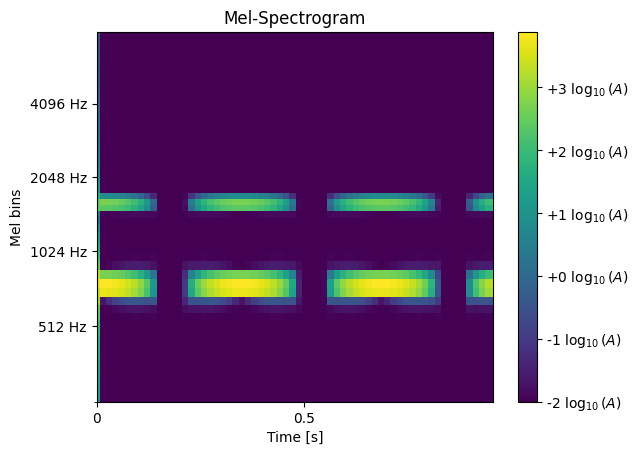

In [38]:
# concept 3
concept = class_params['class1']['concept3']

modulating_amplitude = modulating_amp(np.random.choice(concept['f_amp']), get_phase(), shift=3/4)
signal = modulating_amplitude * harmonic_sig(np.random.choice(concept['f_range']))
signal13 = signal
mel = tomel(torch.tensor(signal, dtype=torch.float))
mel13 = np.log10(mel.numpy()+0.01).squeeze()
plot_spectrogram(np.log10(mel.numpy()+0.01).squeeze(), case='toy')
Audio(signal, rate=16000)

16


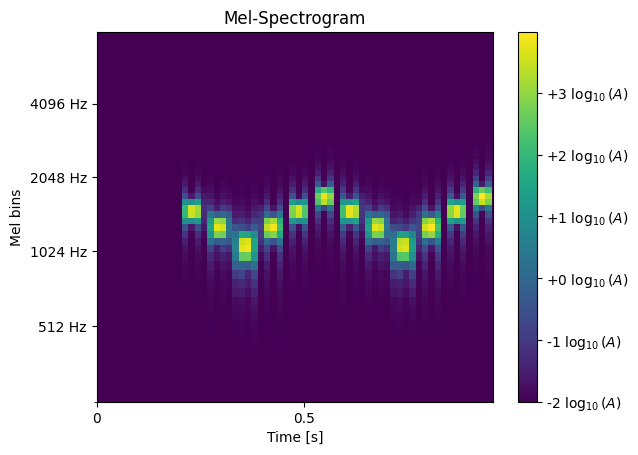

In [20]:
# CLASS 2
# c1
concept = class_params['class2']['concept3']

f_amp = np.random.choice(concept['f_amp'])
print(f_amp)
phase_amp = get_phase()
modulating_amplitude = modulating_amp(f_amp, phase_amp)
freq = get_rand(concept['f_range'])
freq = 1100

sig = alternating_sig(freq, f_amp, phase_amp, modulating_amplitude)
signal23 = sig
mel = tomel(torch.tensor(sig, dtype=torch.float))
mel23 = np.log10(mel.numpy()+0.01).squeeze()
plot_spectrogram(np.log10(mel.numpy()+0.01).squeeze(), case='toy')
Audio(sig[None], rate=16000)

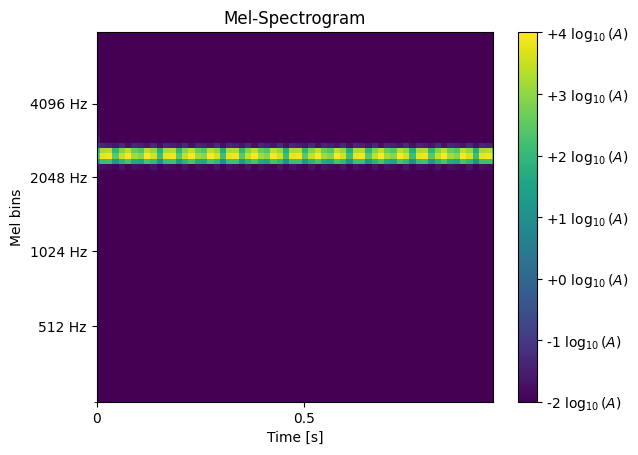

In [12]:
# CLASS 1
concept = class_params['class1']['concept4']

sig = sinusoid_sig(get_rand(concept['f_range'])) * modulating_amp(get_rand(concept['f_amp']), get_phase(), shift=1)
sig = sinusoid_sig(2500) * modulating_amp(get_rand(concept['f_amp']), get_phase(), shift=1)
signal14 = sig
mel = tomel(torch.tensor(sig, dtype=torch.float))
mel14 = np.log10(mel.numpy()+0.01).squeeze()
plot_spectrogram(np.log10(mel.numpy()+0.01).squeeze(), case='toy')
Audio(sig[None], rate=16000)

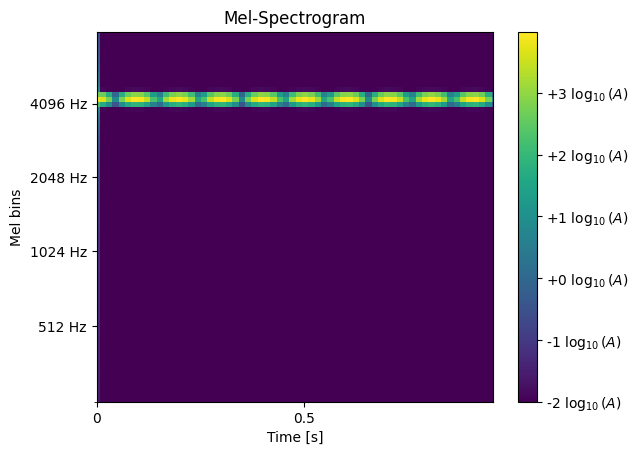

In [13]:
# CLASS 2
concept = class_params['class2']['concept4']

sig = sinusoid_sig(get_rand(concept['f_range'])) * modulating_amp(get_rand(concept['f_amp']), get_phase(), shift=1)
signal24 = sig
mel = tomel(torch.tensor(sig, dtype=torch.float))
mel24 = np.log10(mel.numpy()+0.01).squeeze()
plot_spectrogram(np.log10(mel.numpy()+0.01).squeeze(), case='toy')
Audio(sig[None], rate=16000)

In [14]:
def get_exp_freq(exclude_ranges, tolerance=0):
    # sample frequency from exponential distribution with scale=scale
    # ensure with max(.,.) that minimum frequency is 1Hz
    #return max(1, int(np.random.exponential(scale=scale)))
    while True:
        f = max(1, int(np.random.exponential(scale=scale)))
        if not any(lower-tolerance <= f <= upper+tolerance for lower, upper in exclude_ranges):
            return f
        #if not f >= exclude_ranges[0]-tolerance  and f <= exclude_ranges[1]+tolerance:
        #    return f

def add_random(concept_params, ns=3):
    signal = np.zeros(16000)
    
    for _ in range(ns):
        exp_freq = get_exp_freq(exclude_ranges=(concept_params['concept1']['f_range'],
                                                concept_params['concept2']['f_range'],
                                                concept_params['concept3']['f_range'],
                                                concept_params['concept4']['f_range'],
                                                ), tolerance=50)
        #exp_freq = get_exp_freq(exclude_ranges=concept_params['concept4']['f_range'], tolerance=50)

        s = get_amp(0.1, 1.) * np.sin(2 * np.pi * n * exp_freq / N + get_phase())
        # add modulating amplitude with p=0.5
        if random.randint(0,2) == 1:
            modulating_amplitude = modulating_amp(get_rand(random_concepts['f_amp']), get_phase(), shift=2)
            signal += s * modulating_amplitude
        else:
            signal += s

    return signal

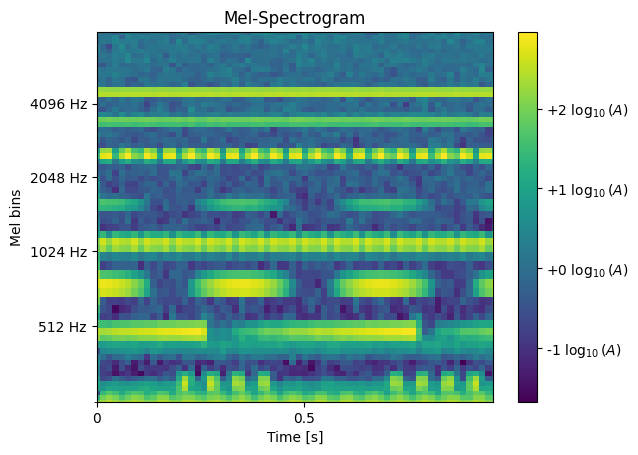

In [40]:
signal1 = signal11 + signal12 + signal13 + signal14
signal1 += add_random(class_params['class1'], ns=5)
signal1 += 0.1 * np.random.normal(0, 1, N)
signal1 = norm(signal1)
mel = tomel(torch.tensor(signal1, dtype=torch.float))
mel1 = np.log10(mel.numpy()+0.01).squeeze()
plot_spectrogram(np.log10(mel.numpy()+0.01).squeeze(), case='toy')
Audio(sig[None], rate=16000)

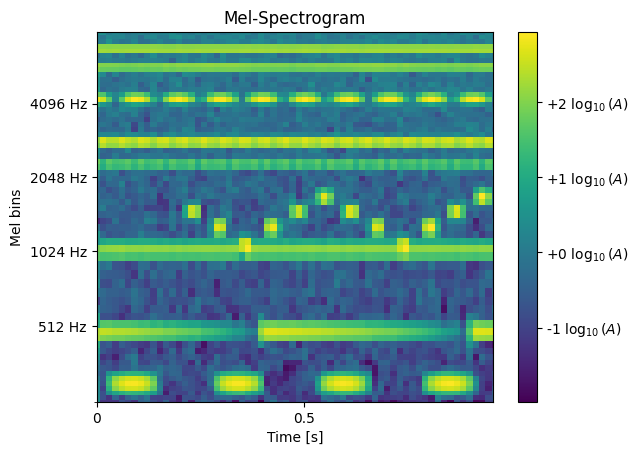

In [37]:
signal2 = signal21 + signal22 + signal23 + signal24
signal2 += add_random(class_params['class1'], ns=5)
signal2 += 0.1 * np.random.normal(0, 1, N)
signal2 = norm(signal2)
mel = tomel(torch.tensor(signal2, dtype=torch.float))
mel2 = np.log10(mel.numpy()+0.01).squeeze()
plot_spectrogram(np.log10(mel.numpy()+0.01).squeeze(), case='toy')
Audio(sig[None], rate=16000)

In [42]:
save = False

if save:
    path_to_auds = f'/Users/samuelharck/Desktop/masterthesis/drsa-audio-results/toy/class1'

    # save audios
    torchaudio.save(os.path.join(path_to_auds, 'final_sample.mp3'), torch.tensor(signal2[None]), sample_rate=16000)
    for i, wav in enumerate([signal11, signal12, signal13, signal14], start=1):
        torchaudio.save(os.path.join(path_to_auds, f'concept{i}.mp3'), torch.tensor(wav[None]), sample_rate=16000)

mp3 None None None ===> None None None
mp3 None None None ===> None None None
mp3 None None None ===> None None None
mp3 None None None ===> None None None
mp3 None None None ===> None None None


## Some visualizations

In [44]:
import librosa
def plot_spectrogram(mel, ax=None, sr=16000, case=None, n_c=4, colorbar=True, remove=False, title=None, suptitle=''):
    '''
    Plots spectrogram

    Parameters
    ----------
    spectrogram: torch.Tensor
        spectrogram in any form (mel-spectrogram, dB, ...)
    sr: int
        sample rate
    title: string
        title for plot
    '''

    mel = mel.squeeze()

    # to numpy for pyplot
    if not isinstance(mel, np.ndarray):
        mel = mel.numpy()

    # define frequencies to plot on y axis
    frequencies = [512, 1024, 2048, 4096]
    # convert freqs to mel bins
    mel_bins = librosa.hz_to_mel(frequencies)

    
    if ax is None:
        fig, ax = plt.subplots()
        ax.set_title(label='Mel-Spectrogram')
    else:
        # adjust ittle for drsa subplot
        if n_c == 2:
            ax.set_title(label='Mel-Spectrogram')#, y=1.12, size=15)
        elif n_c == 4:
            ax.set_title(label='Mel-Spectrogram') if title is None else ax.set_title(label=title)

    # Create the plot
    img = librosa.display.specshow(mel, x_axis='time', y_axis='mel', sr=sr, hop_length=240 if case == 'toy' else 360, ax=ax, htk=True, cmap='viridis')
    if colorbar==True:
        ax.figure.colorbar(img, ax=ax, format='%+2.0f ' + r'$\log_{10}(A)$')

    # set y-ticks to the desired frequencies
    ax.set_yticks(librosa.mel_to_hz(mel_bins))
    ax.set_yticklabels([f'{freq} Hz' for freq in frequencies])

    if case=='toy':
        ax.set_xticks([0, mel.shape[-1]/2/68, mel.shape[-1]/68])
        ax.set_xticklabels(['0', '0.5', '1'])
    else:
        ax.set_xticks(np.arange(6)/(2))

    

    if remove:
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])
        ax.axis('off')
    else:
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Mel bins')

    #ax.set_title(label='Mel-Spectrogram', y=1.06)

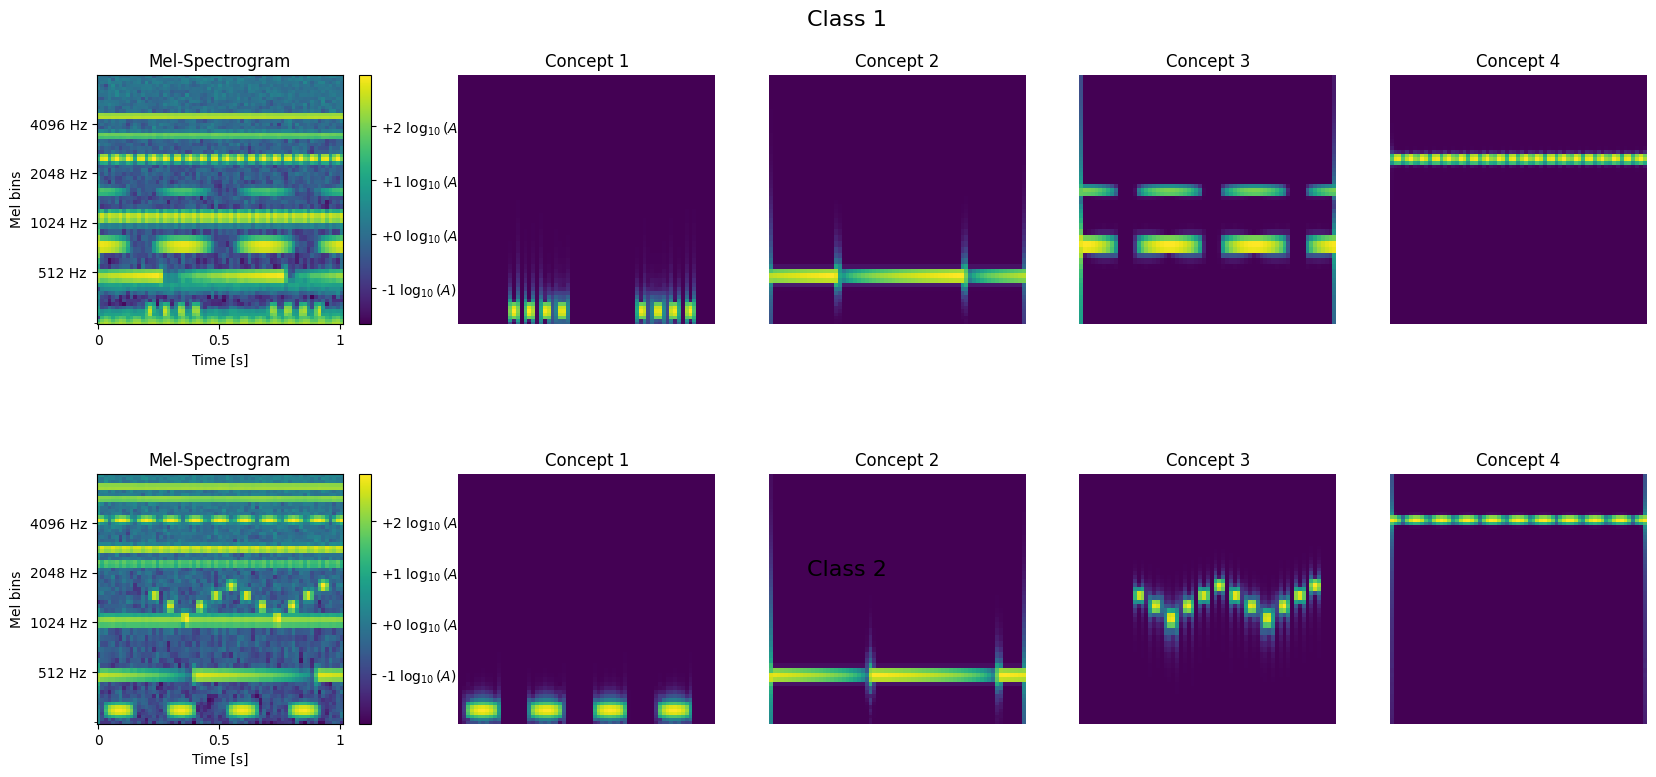

In [45]:
import matplotlib.gridspec as gridspec

# Create a figure and a grid of subplots
#fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # Adjust figsize to fit your screen
fig = plt.figure(figsize=(20, 11))

# Define the width ratios, first column 20% larger than the others
width_ratios = [1.2] + [1]*4
gs = gridspec.GridSpec(2, 5, figure=fig, width_ratios=width_ratios, height_ratios=[1,1])#, hspace=0.4)
axs = gs
# Update the gridspec to use these width ratios
#gs.update(width_ratios=width_ratios)
#axs = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(5)]


plot_spectrogram(mel1, ax=fig.add_subplot(axs[0,0]), case='toy')
plot_spectrogram(mel2, ax=fig.add_subplot(axs[1,0]), case='toy')

for i, mel in enumerate([mel11, mel12, mel13, mel14]):
    plot_spectrogram(mel, ax=fig.add_subplot(axs[0,i+1]), case='toy', colorbar=False, remove=True, title=f'Concept {i+1}')

for i, mel in enumerate([mel21, mel22, mel23, mel24]):
    plot_spectrogram(mel, ax=fig.add_subplot(axs[1,i+1]), case='toy', colorbar=False, remove=True, title=f'Concept {i+1}')

fig.text(0.5, 0.75, 'Class 1', ha='center', va='center', fontsize=16)  # Adjust vertical alignment as needed
fig.text(0.5, 0.25, 'Class 2', ha='center', va='center', fontsize=16)
#plt.subplots_adjust(top=0.85, hspace=0.5)

#plt.subplots_adjust(top=1.8)
plt.subplots_adjust(top=0.7, hspace=0.6)  # Adjust top spacing
#plt.tight_layout(rect=[0, 0, 0.9, 0.7])
#plt.tight_layout()  # Adjust subplots to fit into the figure area nicely
plt.show()

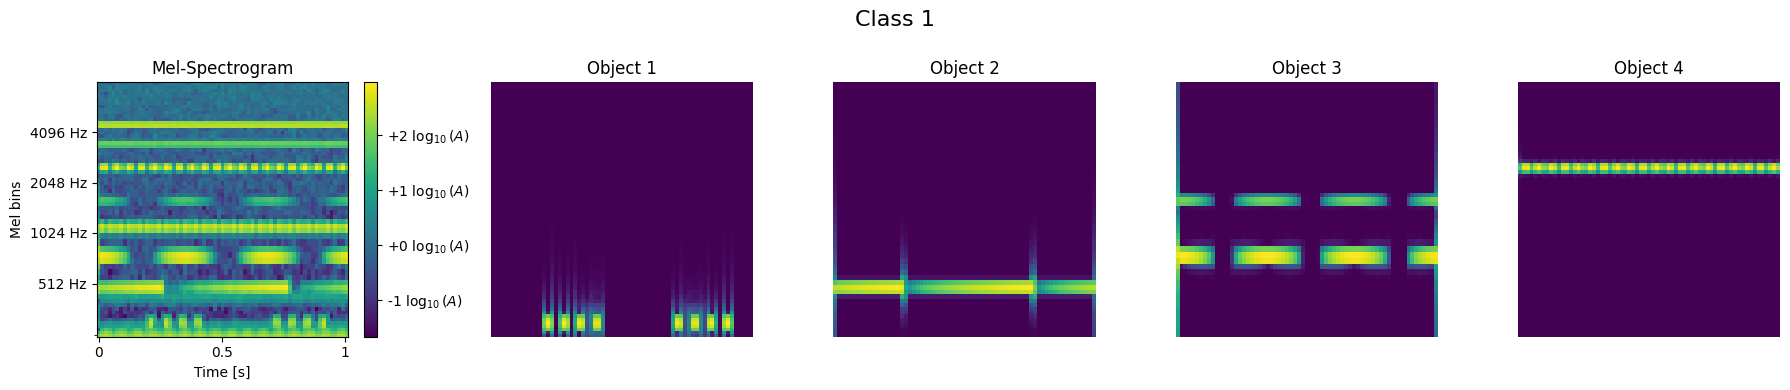

In [46]:
import matplotlib.gridspec as gridspec

# Create a figure and a grid of subplots
#fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # Adjust figsize to fit your screen
fig = plt.figure(figsize=(20, 5))

# Define the width ratios, first column 20% larger than the others
width_ratios = [1.2] + [1]*4
gs = gridspec.GridSpec(1, 5, figure=fig, width_ratios=width_ratios)#, hspace=0.4)
axs = gs
# Update the gridspec to use these width ratios
#gs.update(width_ratios=width_ratios)
#axs = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(5)]

plot_spectrogram(mel1, ax=fig.add_subplot(axs[0,0]), case='toy')
for i, mel in enumerate([mel11, mel12, mel13, mel14]):
    plot_spectrogram(mel, ax=fig.add_subplot(axs[0,i+1]), case='toy', colorbar=False, remove=True, title=f'Object {i+1}')

fig.text(0.45, 0.75, 'Class 1', ha='center', va='center', fontsize=16)  # Adjust vertical alignment as needed

plt.tight_layout(rect=[0, 0, 0.9, 0.7])
#plt.tight_layout()  # Adjust subplots to fit into the figure area nicely
plt.show()

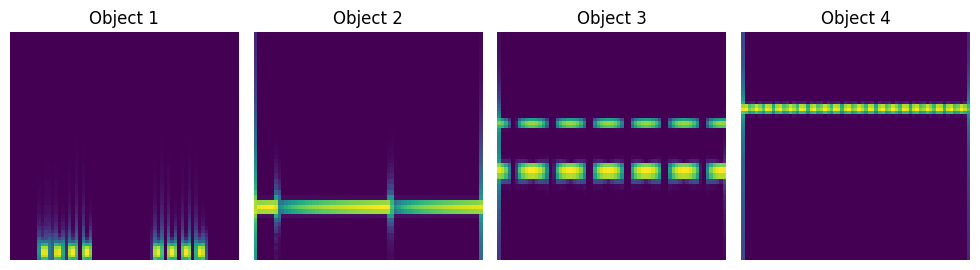

In [147]:
import matplotlib.gridspec as gridspec

# Create a figure and a grid of subplots
#fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # Adjust figsize to fit your screen
fig = plt.figure(figsize=(11, 4))

# Define the width ratios, first column 20% larger than the others
width_ratios = [1]*4
gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=width_ratios)#, hspace=0.4)
axs = gs
# Update the gridspec to use these width ratios
#gs.update(width_ratios=width_ratios)
#axs = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(5)]

#plot_spectrogram(mel1, ax=fig.add_subplot(axs[0,0]), case='toy')
for i, mel in enumerate([mel11, mel12, mel13, mel14]):
    plot_spectrogram(mel, ax=fig.add_subplot(axs[0,i]), case='toy', colorbar=False, remove=True, title=f'Object {i+1}')

#fig.text(0.45, 0.75, 'Class 1', ha='center', va='center', fontsize=16)  # Adjust vertical alignment as needed

plt.tight_layout(rect=[0, 0, 0.9, 0.7])
#plt.tight_layout()  # Adjust subplots to fit into the figure area nicely
plt.show()

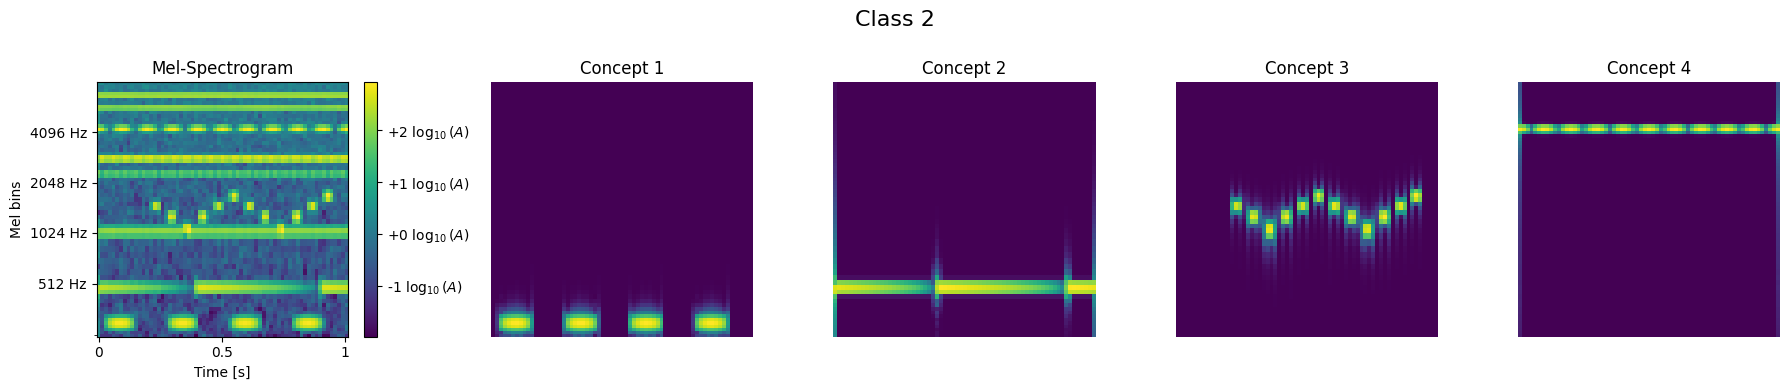

In [47]:
import matplotlib.gridspec as gridspec

# Create a figure and a grid of subplots
#fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # Adjust figsize to fit your screen
fig = plt.figure(figsize=(20, 5))

# Define the width ratios, first column 20% larger than the others
width_ratios = [1.2] + [1]*4
gs = gridspec.GridSpec(1, 5, figure=fig, width_ratios=width_ratios)#, hspace=0.4)
axs = gs
# Update the gridspec to use these width ratios
#gs.update(width_ratios=width_ratios)
#axs = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(5)]

plot_spectrogram(mel2, ax=fig.add_subplot(axs[0,0]), case='toy')
for i, mel in enumerate([mel21, mel22, mel23, mel24]):
    plot_spectrogram(mel, ax=fig.add_subplot(axs[0,i+1]), case='toy', colorbar=False, remove=True, title=f'Concept {i+1}')

fig.text(0.45, 0.75, 'Class 2', ha='center', va='center', fontsize=16)  # Adjust vertical alignment as needed

plt.tight_layout(rect=[0, 0, 0.9, 0.7])
#plt.tight_layout()  # Adjust subplots to fit into the figure area nicely
plt.show()

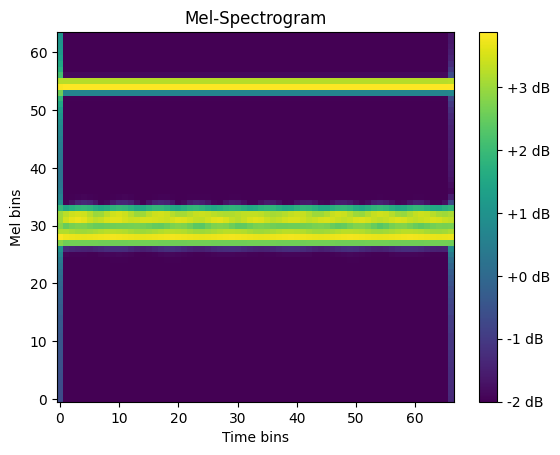

In [31]:
sig = add_random(class_params['class1'], ns=5)

mel = tomel(torch.tensor(sig, dtype=torch.float))
plot_spectrogram(np.log10(mel.numpy()+0.01).squeeze())
Audio(sig[None], rate=16000)

# Main loop to create dataset

In [122]:
def shuffle_and_split(songs, split=[0.7, 0.1, 0.2]):
    songnames = songs
    np.random.shuffle(songnames)
    length = len(songs)

    train_split = songs[:int(split[0]*length)]
    valid_split = songs[int(split[0]*length):int((split[0]+split[1])*length)]
    test_split = songs[int((split[0]+split[1])*length):]
    return [train_split, valid_split, test_split]

def save_data(path, data, splits = ["train_split", "valid_split", "test_split"]):
    for i, split in enumerate(splits):
        with open(os.path.join(path, split + ".txt"), "w") as output:
            for item in data[i]:
                # write each item on a new line
                output.write("%s\n" % item)

In [123]:
random.seed(42)
np.random.seed(42)

path_to_data = '/Users/samuelharck/Desktop/masterthesis/toydata/sythetic'

# lists to save toy data
class1_samplenames = []
class2_samplenames = []
data_class1 = []
data_class2 = []
# for evaluation purposes
all4 = []

N = 16000
n = np.arange(N)
noise_strength = 0.01 # noise strength for gaussian noise
n_concepts = 4

datapoints_per_class = 2000

t0 = time.time()
for i in range(datapoints_per_class):

    for class_idx in range(1, len(class_params.keys())+1):

        concept_params = class_params[f'class{class_idx}']

        # sample num of concepts to include in sample
        n_c = np.random.choice(np.arange(1, n_concepts+1), p=[0.5,0.2,0.2,0.1])
        #n_c = random.randint(1,4)
        #n_c = 4

        # sample ids of concepts to include
        concept_idcs = np.random.choice(np.arange(1,n_concepts+1), n_c, replace=False)

        if class_idx == 1:
            signal = generate_class1_sample(concept_params, concept_idcs)
        else:
            signal = generate_class2_sample(concept_params, concept_idcs)

        # add random concepts to increase complexity
        signal += add_random(concept_params, ns=get_rand([3,5]))

        # add noise with defined strength 0.01 for clean task and 0.8 for noisy task
        signal += noise_strength * np.random.normal(0, 1, N)

        # normalize
        signal = norm(signal)

        # save as .mp3-file
        filename = f"class{class_idx}/{i+1:05d}.mp3"
        if not os.path.exists(os.path.join(path_to_data, f"class{class_idx}")): os.makedirs(os.path.join(path_to_data, f"class{class_idx}"))
        scipy.io.wavfile.write(os.path.join(path_to_data, filename), 16000, signal)
        class1_samplenames.append(filename) if class_idx == 1 else class2_samplenames.append(filename)
        data_class1.append(signal) if class_idx == 1 else data_class2.append(signal)

        if n_c == 4:
            all4.append(filename)
        

# make lists for train, valid and test split
train_split = []
valid_split = []
test_split  = [] 

for class_ in [class1_samplenames, class2_samplenames]:
    tr, vl, ts = shuffle_and_split(class_, split=[0.7, 0.1, 0.2])
    train_split.extend(tr), valid_split.extend(vl), test_split.extend(ts)

save_data(path_to_data, [train_split, valid_split, test_split])
save_data(path_to_data, [all4], ['all4'])

t1 = time.time()

print(f'Time to gernerate dataset ({datapoints_per_class} datapoints per class): {t1-t0:5.2f} s')

Time to gernerate dataset (2000 datapoints per class): 10.24 s


## Load and inspect datapoints

In [55]:
path_to_data = '/Users/samuelharck/Desktop/masterthesis/toydata/sythetic'
songlist = []
with open(os.path.join(path_to_data, 'all4.txt')) as f:
    lines = f.readlines()
for line in lines:
    songlist.append(os.path.join(path_to_data, line.strip()))

len(songlist)
c1 = []
c2 = []
for song in songlist:
    if song.split('/')[-2] == 'class1':
        c1.append(song)
    else:
        c2.append(song)

/var/folders/sx/8wjp4vss4ld0zf0ln0pxp53m0000gn/T/ipykernel_67569/363363003.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mel = tomel(torch.tensor(sig, dtype=torch.float))


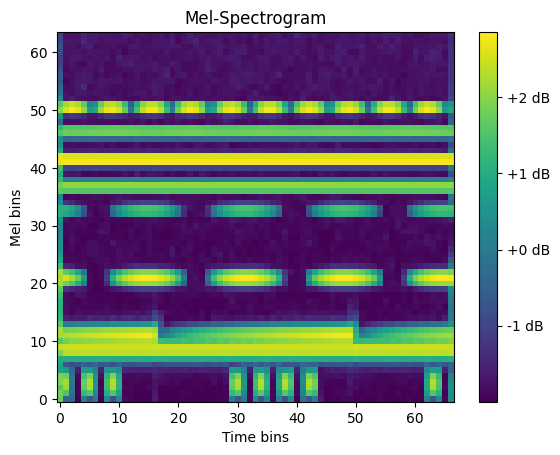

In [57]:
#sig = data_class1[1]
idx = 3
sig, _ = torchaudio.load(c1[idx])
mel = tomel(torch.tensor(sig, dtype=torch.float))
plot_spectrogram(np.log10(mel.numpy()+0.01).squeeze())

/var/folders/sx/8wjp4vss4ld0zf0ln0pxp53m0000gn/T/ipykernel_67569/3607907425.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mel = tomel(torch.tensor(sig, dtype=torch.float))


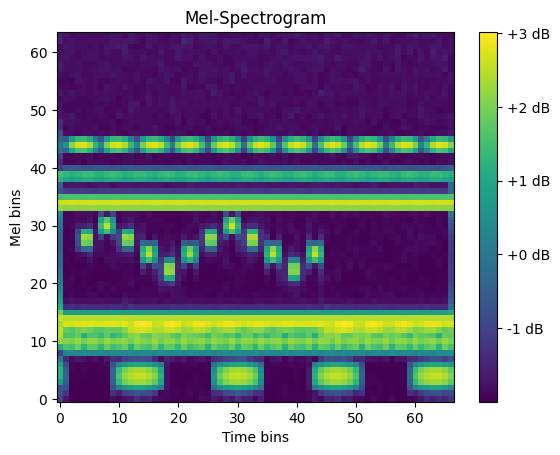

In [58]:
#sig = data_class1[1]
idx = 14
sig, _ = torchaudio.load(c2[idx])
mel = tomel(torch.tensor(sig, dtype=torch.float))
plot_spectrogram(np.log10(mel.numpy()+0.01).squeeze())

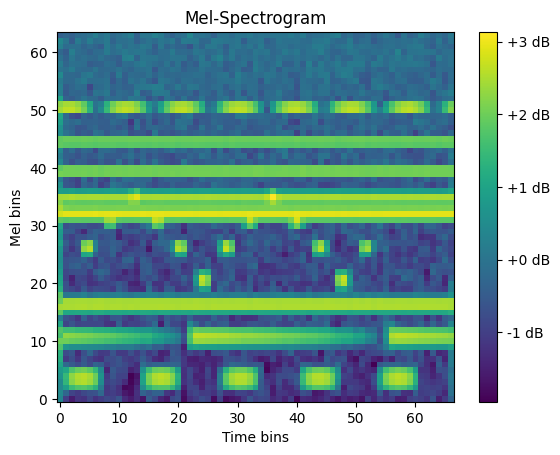

In [30]:
sig = data_class2[2]

mel = tomel(torch.tensor(sig, dtype=torch.float))
plot_spectrogram(np.log10(mel.numpy()+0.01).squeeze())
Audio(sig[None], rate=16000)